## 환경 설정

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-0l3f4bej
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-0l3f4bej
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 KB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 881.9/881.9 MB 109.6 MB/s eta 0:00

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import gluonnlp as nlp
from tqdm.notebook import tqdm

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/이창대_kaggle/11번가_리뷰긍부정_20만.csv', encoding='utf-8-sig', index_col=0)

In [ ]:
data.head()

,상품명,날짜,ID,평점,리뷰,꾹
0,[홈플러스]신선특란30입,2022.05.28,luck*****,4,깨진것없이 잘받았어요계란은 애들이 잘먹어서 미리 사놓게되네요,0
1,[20%+T11%+묶음10%] 닥터지 추석 브랜드위크! 피부건강 선물기획 外 BES...,2021.11.13,lavi****,4,겨울철 보습크림으로 꼭 쟁여두는데 1+1이라서 당분간은 걱정없이 잘 쓸거같아요~,0
2,KF94 KF-AD 여름용 아이코코 마스크 비말차단 / 컬러에디션 초소형 소형 S ...,2022.08.13,구월이,4,사이즈가 작아요. 초소형으로 보면 될것같아요.,0
3,[3M] 베이직 더블액션 물걸레 청소포 120매 외 막대걸레 밀대 청소포리필,2019.11.09,mamm***,4,"늘 간단히 청소하기 편해서 구매했는데,가격이 부담이었는데.이번에 저렴하게 잘 구매했...",0
4,[기프티콘] 이마트/트레이더스 5만원권,2022.08.07,진달래뿅뿅,4,잘썼습니다잘썼습니다,0


In [ ]:
len(data)

193889

# EDA

In [ ]:
import seaborn as sns

In [ ]:
data['평점'].value_counts()

4    50000
5    50000
2    47406
1    46483
Name: 평점, dtype: int64

In [ ]:
review_length = []
for review in data['리뷰']:
    review_length.append(len(review))

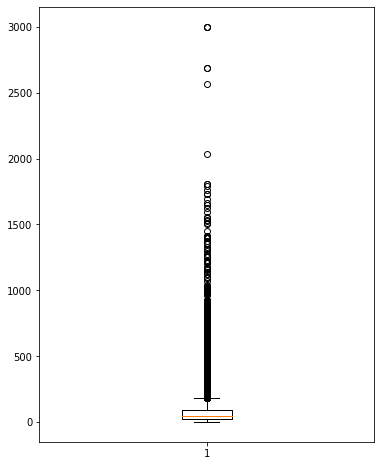

In [ ]:
plt.figure(figsize=(6,8))
plt.boxplot(review_length)
plt.show()

In [ ]:
q1 = np.percentile(review_length,25)
q2 = np.percentile(review_length,50)
q3 = np.percentile(review_length,75)

In [ ]:
print('사분위수', q1,q2,q3)
print('단어 길이수 27~90이 전체의 50%를 차지함')

사분위수 27.0 49.0 90.0
단어 길이수 27~90이 전체의 50%를 차지함


In [ ]:
# 상품개수 1254개
len(set(data['상품명']))

1254

In [ ]:
# 전체 데이터(20만) 중 리뷰 쓴 사람 수 8.6만명
len(set(data['ID'])), len(data)

(86133, 193889)

# 평점을 0 부정, 1 긍정으로 바꿔주기

In [ ]:
# 평점 0점, 1점으로 바꿔주기
rate = []
for review in data['평점']:
    if review >3:
        rate.append(1)
    else:
        rate.append(0)

In [ ]:
data['sentiment'] = rate

In [ ]:
data.head()

,상품명,날짜,ID,평점,리뷰,꾹,sentiment
0,[홈플러스]신선특란30입,2022.05.28,luck*****,4,깨진것없이 잘받았어요계란은 애들이 잘먹어서 미리 사놓게되네요,0,1
1,[20%+T11%+묶음10%] 닥터지 추석 브랜드위크! 피부건강 선물기획 外 BES...,2021.11.13,lavi****,4,겨울철 보습크림으로 꼭 쟁여두는데 1+1이라서 당분간은 걱정없이 잘 쓸거같아요~,0,1
2,KF94 KF-AD 여름용 아이코코 마스크 비말차단 / 컬러에디션 초소형 소형 S ...,2022.08.13,구월이,4,사이즈가 작아요. 초소형으로 보면 될것같아요.,0,1
3,[3M] 베이직 더블액션 물걸레 청소포 120매 외 막대걸레 밀대 청소포리필,2019.11.09,mamm***,4,"늘 간단히 청소하기 편해서 구매했는데,가격이 부담이었는데.이번에 저렴하게 잘 구매했...",0,1
4,[기프티콘] 이마트/트레이더스 5만원권,2022.08.07,진달래뿅뿅,4,잘썼습니다잘썼습니다,0,1


In [ ]:
# 긍/부정 분류 완료
data['sentiment'].value_counts()

1    100000
0     93889
Name: sentiment, dtype: int64

In [ ]:
data_list = []

for review, label in zip(data['리뷰'], data['sentiment']):
  temp = []
  temp.append(review)
  temp.append(label)
  data_list.append(temp)

len(data_list)

193889

In [ ]:
data_list[:5]

[['깨진것없이 잘받았어요계란은 애들이 잘먹어서 미리 사놓게되네요', 1],
 ['겨울철 보습크림으로 꼭 쟁여두는데 1+1이라서 당분간은 걱정없이 잘 쓸거같아요~', 1],
 ['사이즈가 작아요. 초소형으로 보면 될것같아요.', 1],
 ['늘 간단히 청소하기 편해서 구매했는데,가격이 부담이었는데.이번에 저렴하게 잘 구매했네요.바닥이 잘 닦이고 좋아요', 1],
 ['잘썼습니다잘썼습니다', 1]]

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_list, test_size = 0.2, shuffle=True, random_state = 7)

In [ ]:
train[:3], test[:3]

([['솔직히 엄청 느린거에 비해 상품이 특별히 예쁜것도 아닌것 같고 진짜 싼맛에 사는 느낌? 샀는데 다 따로와서 환불하기 귀찮아서 안했는데 하나하나 다 오고 다 입어보니 너무 별로라 할 말을 잃음 상품 사진이랑도 너무 다름 제품 자체 하자 너무 많음 할 말을 잃음.. 심지어 옷에 먼진지.. 무슨 가루 같은게 외투에 덕지덕지 붙어서 오고, 옷 접는 모양의 구깃함이 아니라 걍 구깃꾸깃 안접은곳도 구깃구깃해여 케바켄가 모르겠네여 개인적으로 돈이 매우매우 아깝 사진이 다했단 말이 정확',
   0],
  ['지인선물사면서 이참에 어머니 핸드폰에도 강화유리 필름 붙여드리면 좋을 것 같아 어머니것도 샀습니다. 지인분은 지문인식이 전혀안된다고 하여 바로 떼어내셨다고 하네요. 어머니폰은 다를까해서 붙여봤는데 아니나 다를까 어머니 핸드폰도 지문인식이 전혀안되서 그냥 바로 떼어냈습니다. 아이폰은 지문인식이 없어 전혀 불편함없이 사용했었는데 갤럭시는 지문인식 부분이 얇아도 전혀 인식하지 못하는게 너무 아쉽네요. 재구매 의사 없습니다 ㅜㅜ',
   0],
  ['바지 아이보리 블랙 종류도 다르게 샀는데둘다 세탁하니 7부 8부 됐어요 키 165입니다그래서 키 작은 친구 주게요160이하분들이 복숭아뼈 위로 맞으실듯',
   0]],
 [['옷은 괜찬은데 배송은 기간은 거의한달이 걸렸어 왔네요', 0],
  ['무라벨로 왔어요행사가로 잘 구매했네요~', 1],
  ['모카골드로 주문한다는것이 주문을 잘못 했습니다 큰일 났네요 저거 다먹을려면 아무튼 잘받았습니다', 0]])

## KoBERT tokenizer, model

[CLS] : classification token (문장의 시작)

[SEP] : seperate (문장 구분)

[MASK] : MASK

[PAD] : PADDING

In [ ]:
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
tok.vocab

Vocab(size=8002, unk="[UNK]", reserved="['[CLS]', '[SEP]', '[MASK]', '[PAD]']")

In [ ]:
vocab

Vocab(size=8002, unk="[UNK]", reserved="['[CLS]', '[SEP]', '[MASK]', '[PAD]']")

# Dataset

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [i[label_idx] for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

# Parameter

In [ ]:
max_len = 90 # 3사분위수인 90
batch_size = 64
warmup_ratio = 0.1
num_epochs = 3
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
train_dataset = BERTDataset(train, 0, 1, tok, max_len, True, False)
test_dataset = BERTDataset(test, 0, 1, tok, max_len, True, False)

In [ ]:
train_dataset.labels[:3]

[0, 0, 0]

In [ ]:
test_dataset.sentences[:3]

[(array([   2, 3454, 7086,  517, 5484, 7395, 7086, 5850, 2287, 6621, 7086,
         1259, 7086,  873, 7828, 5793, 7096,  889, 6072, 6855,  517, 6989,
         5703,    3,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1], dtype=int32),
  array(24, dtype=int32),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0], dtype=int32)),
 (array

# DataLoader

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=5)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# KoBERT 모델

In [ ]:
class BERTClassifier(nn.Module):
  def __init__(self, bert, hidden_size=768, num_classes=2, dr_rate=None, params=None):
    super(BERTClassifier, self).__init__()
    self.bert = bert
    self.dr_rate = dr_rate

    self.classifier = nn.Linear(hidden_size , num_classes)
    if dr_rate:
      self.dropout = nn.Dropout(p=dr_rate)

  def gen_attention_mask(self, token_ids, valid_length):
    attention_mask = torch.zeros_like(token_ids)
    for i, v in enumerate(valid_length):
      attention_mask[i][:v] = 1
    return attention_mask.float()

  def forward(self, token_ids, valid_length, segment_ids):
    attention_mask = self.gen_attention_mask(token_ids, valid_length)
    _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
    if self.dr_rate:
        out = self.dropout(pooler)
    else:
        out = pooler
    return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

# optimizer and schedule

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']

# 최적화해야 할 parameter를 optimizer에게 알려야 함
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate) # optimizer
loss_fn = nn.CrossEntropyLoss() # loss function 

In [ ]:
t_total = len(train_loader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

# Calculate Accuracy

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# Train

In [ ]:
for e in range(num_epochs):
    
    train_acc = 0.0
    test_acc = 0.0
    
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()
        
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/2424 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.7751858234405518 train acc 0.34375
epoch 1 batch id 201 loss 0.23761172592639923 train acc 0.8429726368159204
epoch 1 batch id 401 loss 0.15054847300052643 train acc 0.88606608478803
epoch 1 batch id 601 loss 0.22422362864017487 train acc 0.9005563643926788
epoch 1 batch id 801 loss 0.036198653280735016 train acc 0.9054307116104869
epoch 1 batch id 1001 loss 0.24875566363334656 train acc 0.9090128621378621
epoch 1 batch id 1201 loss 0.10963252931833267 train acc 0.9114149666944213
epoch 1 batch id 1401 loss 0.21557804942131042 train acc 0.9138450214132763
epoch 1 batch id 1601 loss 0.21916061639785767 train acc 0.9154532323547783
epoch 1 batch id 1801 loss 0.14790450036525726 train acc 0.9168691004997224
epoch 1 batch id 2001 loss 0.22073620557785034 train acc 0.918517303848076
epoch 1 batch id 2201 loss 0.2431250512599945 train acc 0.9196600976828714
epoch 1 batch id 2401 loss 0.12258856743574142 train acc 0.9210875676801332
epoch 1 train acc 0.92125023800456

  0%|          | 0/606 [00:00<?, ?it/s]

epoch 1 test acc 0.9384691163081825


  0%|          | 0/2424 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.08665326237678528 train acc 0.96875
epoch 2 batch id 201 loss 0.14562825858592987 train acc 0.9338463930348259
epoch 2 batch id 401 loss 0.11908233165740967 train acc 0.9360193266832918
epoch 2 batch id 601 loss 0.19502608478069305 train acc 0.9387999168053245
epoch 2 batch id 801 loss 0.013065352104604244 train acc 0.941186797752809
epoch 2 batch id 1001 loss 0.14215880632400513 train acc 0.9430257242757243
epoch 2 batch id 1201 loss 0.08820764720439911 train acc 0.9444993755203996
epoch 2 batch id 1401 loss 0.14057548344135284 train acc 0.9456303533190579
epoch 2 batch id 1601 loss 0.13839244842529297 train acc 0.9463909275452842
epoch 2 batch id 1801 loss 0.11572251468896866 train acc 0.9474250416435314
epoch 2 batch id 2001 loss 0.1853792369365692 train acc 0.948353948025987
epoch 2 batch id 2201 loss 0.17567820847034454 train acc 0.9488868696047251
epoch 2 batch id 2401 loss 0.10689274966716766 train acc 0.9500924094127446
epoch 2 train acc 0.950250103135

  0%|          | 0/606 [00:00<?, ?it/s]

epoch 2 test acc 0.9445336505633322


  0%|          | 0/2424 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.029484830796718597 train acc 1.0
epoch 3 batch id 201 loss 0.0822669267654419 train acc 0.9613650497512438
epoch 3 batch id 401 loss 0.06403997540473938 train acc 0.9619311097256857
epoch 3 batch id 601 loss 0.14158298075199127 train acc 0.9637843178036606
epoch 3 batch id 801 loss 0.022891052067279816 train acc 0.9651217228464419
epoch 3 batch id 1001 loss 0.061128731817007065 train acc 0.9663773726273727
epoch 3 batch id 1201 loss 0.07130413502454758 train acc 0.967266860949209
epoch 3 batch id 1401 loss 0.09525758773088455 train acc 0.9678577801570307
epoch 3 batch id 1601 loss 0.06078893691301346 train acc 0.9684474547158026
epoch 3 batch id 1801 loss 0.03982069343328476 train acc 0.9693833287062743
epoch 3 batch id 2001 loss 0.16815516352653503 train acc 0.970007183908046
epoch 3 batch id 2201 loss 0.11150704324245453 train acc 0.97015561108587
epoch 3 batch id 2401 loss 0.059875987470149994 train acc 0.9706437421907539
epoch 3 train acc 0.970664449257425

  0%|          | 0/606 [00:00<?, ?it/s]

epoch 3 test acc 0.9453533984864003


3 epoch으로 학습 결과 94.5%의 test accuracy를 얻음.

# 모델 저장

In [ ]:
PATH = '/content/drive/MyDrive/이창대_kaggle/'
# torch.save(model, PATH + 'naverShoppingReview.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + '11st_shopping.pt')  # 모델 객체의 state_dict 저장
# torch.save({
#     'model': model.state_dict(),
#     'optimizer': optimizer.state_dict()
# }, PATH + 'all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

In [ ]:
torch.save(model, '/content/drive/MyDrive/이창대_kaggle/11st_shopping_all.pt')

# Input Test

In [ ]:
def predict(predict_sentence):

    data = [predict_sentence, 0]
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_loader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_loader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("부정적")
            else:
                test_eval.append("긍정적")

        print(">> 해당 리뷰는 " + test_eval[0] + " 리뷰 입니다.")

긍부정을 잘 분류하는 것을 확인할 수 있다.

In [ ]:
while True:
    sentence = input("긍부정을 판단할 리뷰를 입력해주세요 : ")
    if sentence == "0":
      print(">> 긍부정 판단을 종료합니다!")
      break
    predict(sentence)
    print("\n")

긍부정을 판단할 리뷰를 입력해주세요 : 포장을 좀 더 신경써 주세요. 입에 대기 찝찝하게 포장박스가 다 벌어져 있는데다 안에 비닐도 밀봉이 되어 있지 않아 마스크가 다 보이네요. 아 찝찝해서 쓰기싫네요. 게다가 택배사에 오래 머물러 있었는데.. 국산이면 뭐합니까. 포장이 엉망..에휴..별한개도 아깝네요. 낱개포장된건 쓰레기 많이 나오는것 같아서 일부러 이거 샀는데, 다른덴 이런식으로 포장 안합니다. 내용물이 괜찮으면 뭐합니까. 완제품 1,2차 포장 방법 개선 하시길.
>> 해당 리뷰는 부정적 리뷰 입니다.


긍부정을 판단할 리뷰를 입력해주세요 : 가격은 착합니다.근대 제조년이 2017년7월이네요.제조일자가 좀 걸립니다.사은품은 누락없이 잘받앗어요.케어러브도 2019년2월까지인대.사용기한 스티커 새로부착대서 올년말입니다.
>> 해당 리뷰는 긍정적 리뷰 입니다.


긍부정을 판단할 리뷰를 입력해주세요 : 급하게 밥이 필요할때 잘 먹고 있어요. 정말 밥하기 싫을때 가족들이 한개씩 데워 먹기도 해요 그런데 많이 녹아 왔어요. 모든 비닐은 터지기 직전이고 여름도 아닌데 이정도면 대형마트에서 사먹어야 겠어요
>> 해당 리뷰는 긍정적 리뷰 입니다.


긍부정을 판단할 리뷰를 입력해주세요 : 별로에요
>> 해당 리뷰는 부정적 리뷰 입니다.


긍부정을 판단할 리뷰를 입력해주세요 : 로얄과주문했는데 맞는지도궁금하고 많은양이터져서 끈적끈적 난리나났네요 왜이럴까요 너무화나요
>> 해당 리뷰는 부정적 리뷰 입니다.


긍부정을 판단할 리뷰를 입력해주세요 : 0
>> 긍부정 판단을 종료합니다!
